In [2]:
#Firist
#freMTPL2freqのデータを使って、VehGas別のClaimNBの数の差の検定（ポアソン分布に従う）を行え。
#ただし、Exposure＞0のみを対象とせよ。
#Second
#HR_Employee_Attritionのデータを使って、Attrition別の年齢と給与の層別回帰分析を行え。

In [3]:
!pip install japanize-matplotlib

In [68]:
import numpy as np
import pandas as pd
import scipy.stats as stat
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib

In [69]:
df1 = pd.read_csv(r"C:\Users\sk062\Downloads\freMTPL2freq.csv")
df2 = pd.read_csv(r"C:\Users\sk062\Downloads\HR_Employee_Attrition.csv")

In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB


In [71]:
df1.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [72]:
# Exposure>0のみに絞る
filtered_df1 = df1[df1['Exposure'] > 0]

In [73]:
filtered_df1.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [74]:
aggregate_result = filtered_df1.groupby('VehGas').agg({'ClaimNb': 'sum', 'Exposure': 'sum'})
aggregate_result

,ClaimNb,Exposure
VehGas,,
Diesel,16648,170660.893127
Regular,19454,187838.552336


In [75]:
def poisson_test(count1, exposure1, count2, exposure2):
    rate1 = count1 / exposure1
    rate2 = count2 / exposure2
    pooled_rate = (count1 + count2) / (exposure1 + exposure2)
    z = (rate1 - rate2) / np.sqrt(pooled_rate * (1/exposure1 + 1/exposure2))
    p_value = 2 * (1 - stats.norm.cdf(np.abs(z)))
    return z, p_value

In [76]:
diesel = aggregate_result.loc['Diesel']
regular = aggregate_result.loc['Regular']

z, p = poisson_test(diesel['ClaimNb'], diesel['Exposure'], regular['ClaimNb'], regular['Exposure'])

print(f"Z値: {z:.3f}, p値: {p:.5f}")

Z値: -5.670, p値: 0.00000



Attrition = Yes の回帰結果:
                             OLS Regression Results                            
Dep. Variable:          MonthlyIncome   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     78.59
Date:                Fri, 23 May 2025   Prob (F-statistic):           1.95e-16
Time:                        10:01:52   Log-Likelihood:                -2245.0
No. Observations:                 237   AIC:                             4494.
Df Residuals:                     235   BIC:                             4501.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1533.5626    74

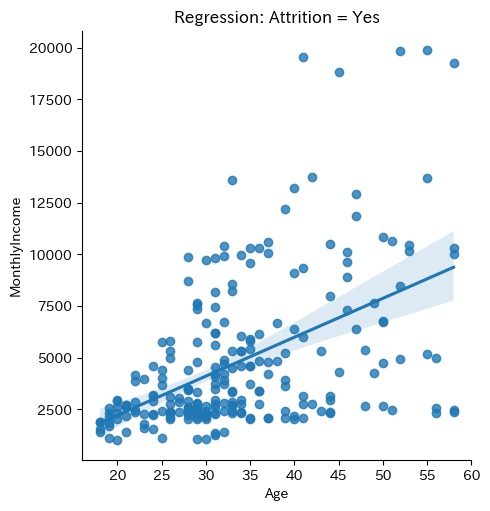


Attrition = No の回帰結果:
                             OLS Regression Results                            
Dep. Variable:          MonthlyIncome   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     382.1
Date:                Fri, 23 May 2025   Prob (F-statistic):           2.52e-74
Time:                        10:01:53   Log-Likelihood:                -12038.
No. Observations:                1233   AIC:                         2.408e+04
Df Residuals:                    1231   BIC:                         2.409e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3077.3229    520

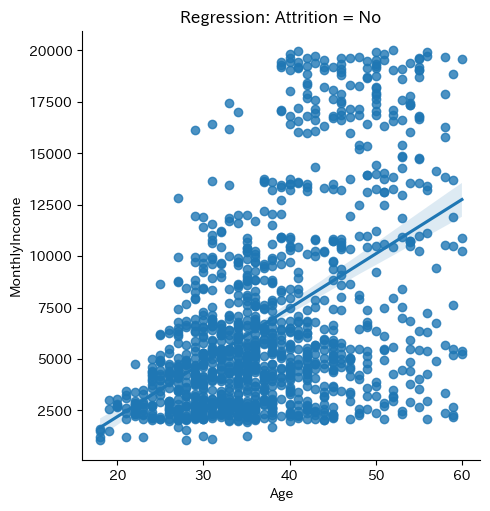

In [78]:
# 層別回帰分析（年齢 → 月給）を Attrition 別に実施
for attr in ['Yes', 'No']:
    subset = df2[df2['Attrition'] == attr]
    X = sm.add_constant(subset['Age'])
    y = subset['MonthlyIncome']
    model = sm.OLS(y, X).fit()
    print(f"\nAttrition = {attr} の回帰結果:\n", model.summary())

    # 散布図 + 回帰直線の可視化
    sns.lmplot(x='Age', y='MonthlyIncome', data=subset)
    plt.title(f'Regression: Attrition = {attr}')
    plt.show()
